# Analyse verdeling PDs binnen een cluster
De lopende hypothese is dat PDs binnen een cluster normaal verdeeld zijn. Hierbij een poging om van de verschillende datasets binnen de gevonden clusters de parameters ($\mu$ en $\sigma$) voor een normale verdeling af te leiden.
Hierbij is het gemiddelde $\mu$ de meest waarschijnlijke plek waar de fout in de kabel zit, en de standaarddeviatie $\sigma$ hangt waarschijnlijk af van de nauwkeurigheid van de meting.
$\mu$ is voor de dataanalyse dus niet zo interessant, maar voor de monteurs in het veld wel. Bij $\sigma$ is dat omgekeerd: Als die tussen de verschillende clusters niet veel varieert, kunnen we daaruit conclusies trekken.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import ipywidgets
from IPython.display import display, clear_output, Javascript, Markdown

import poisson_clustering as ps

In [2]:
circuits, cable_config, partial_discharges, warning = ps.load_data()
circ = circuits[4]
print(circ)
# Lengte van de kabel is gegeven in de cable config
cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]
pardis = partial_discharges[circ]

2806


In [3]:
boolean_series, locations, charges, times, bins = ps.identify_suspicious_areas(pardis, cable_length)

In [4]:
clusters = ps.cluster_boolean_series(boolean_series)
print(clusters)

{(275, 282), (211, 229)}


/home/rick/Documents/Universiteit/Wiskunde/Modellenpracticum/venv/lib/python3.5/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


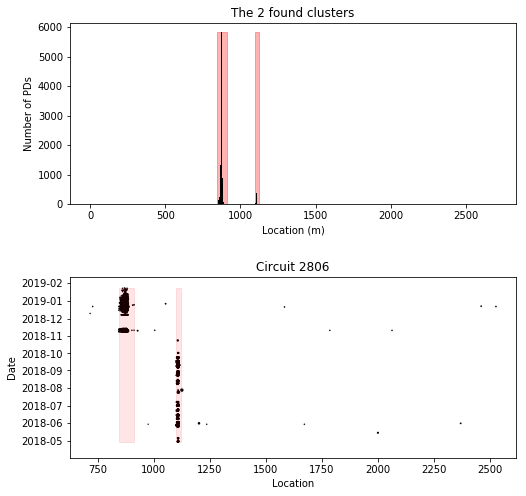

In [5]:
ps.show_plot(locations, times, charges, bins, clusters, circ)

In [6]:
clusters_meters = sorted([tuple(a*4.0 for a in x) for x in clusters], key=lambda x: x[0])
clusters_meters

[(844.0, 916.0), (1100.0, 1128.0)]

In [7]:
def normal_parameters(locations, clusters):
    result = []
    for current_cluster in clusters:
        min_location, max_location = current_cluster[0], current_cluster[1]
        cluster_bools = [min_location <= loc <= max_location for loc in locations] 
        cluster_pds = locations[cluster_bools]
        mu = np.mean(cluster_pds)
        sigma = np.std(cluster_pds)
        result.append((current_cluster, max_location-min_location, mu, sigma))
    return result

In [8]:
normal_parameters(locations, clusters_meters)

[((844.0, 916.0), 72.0, 873.5697521097876, 5.550966954094647),
 ((1100.0, 1128.0), 28.0, 1108.1367176121896, 1.6550244993312642)]

In [9]:
def calculate_all_normal_parameters():
    circuits, cable_config, partial_discharges, warning = ps.load_data()
    result = []
    for circ in circuits:
        # Lengte van de kabel is gegeven in de cable config
        cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]
        pardis = partial_discharges[circ]
        boolean_series, locations, charges, times, bins = ps.identify_suspicious_areas(pardis, cable_length)
        clusters = ps.cluster_boolean_series(boolean_series)
        clusters_meters = [tuple(a*4.0 for a in x) for x in clusters]
        result.extend([tuple((circ,)) + x for x in normal_parameters(locations, clusters_meters)])
    return result

In [10]:
parameters = calculate_all_normal_parameters()

In [11]:
lengths = [x[2] for x in parameters]
mus = [x[3] for x in parameters]
sigmas = [x[4] for x in parameters]
sigmas = np.sort(sigmas)
parameters = sorted(parameters, key=lambda x: x[4])
result = ""
for x in parameters:
    result += "| "
    for i in range(0,5):
        result += str(x[i]) + " | "
    result += "\n"
print(result)

| 2806 | (1100.0, 1128.0) | 28.0 | 1108.1367176121896 | 1.6550244993312642 | 
| 2870 | (976.0, 988.0) | 12.0 | 980.8829568609435 | 3.2315252213453234 | 
| 2870 | (0.0, 12.0) | 12.0 | 2.208600859734895 | 3.450029384328724 | 
| 2063 | (0.0, 12.0) | 12.0 | 3.157297178377678 | 3.542063847856088 | 
| 2870 | (1256.0, 1272.0) | 16.0 | 1263.633490127769 | 3.844411015211924 | 
| 1512 | (812.0, 836.0) | 24.0 | 818.8282229311151 | 4.0750709785626915 | 
| 2870 | (364.0, 396.0) | 32.0 | 381.3406431015938 | 5.090581865328526 | 
| 1512 | (848.0, 872.0) | 24.0 | 860.7841499817422 | 5.105355267443109 | 
| 1512 | (1296.0, 1328.0) | 32.0 | 1309.1197584288266 | 5.1727821718132905 | 
| 2870 | (928.0, 948.0) | 20.0 | 937.7080137337477 | 5.291165597102782 | 
| 2870 | (756.0, 784.0) | 28.0 | 772.0914509772138 | 5.47134252876542 | 
| 2806 | (844.0, 916.0) | 72.0 | 873.5697521097876 | 5.550966954094647 | 
| 1512 | (776.0, 800.0) | 24.0 | 788.6945850812148 | 5.787196445265007 | 
| 2063 | (328.0, 364.0) | 36.0 | 

# Resultaten

| Circuit | Cluster | Lengte cluster | Gemiddelde $\mu$ | Standaarddeviatie $\sigma$ |
|------|------------------|------|--------------------|--------------------|
| 2806 | (1100.0, 1128.0) | 28.0 | 1108.1367176121896 | 1.6550244993312642 | 
| 2870 | (976.0, 988.0)   | 12.0 | 980.8829568609435  | 3.2315252213453234 | 
| 2870 | (0.0, 12.0)      | 12.0 | 2.208600859734895  | 3.450029384328724  | 
| 2063 | (0.0, 12.0)      | 12.0 | 3.157297178377678  | 3.542063847856088  | 
| 2870 | (1256.0, 1272.0) | 16.0 | 1263.633490127769  | 3.844411015211924  | 
| 1512 | (812.0, 836.0)   | 24.0 | 818.8282229311151  | 4.0750709785626915 | 
| 2870 | (364.0, 396.0)   | 32.0 | 381.3406431015938  | 5.090581865328526  | 
| 1512 | (848.0, 872.0)   | 24.0 | 860.7841499817422  | 5.105355267443109  | 
| 1512 | (1296.0, 1328.0) | 32.0 | 1309.1197584288266 | 5.1727821718132905 | 
| 2870 | (928.0, 948.0)   | 20.0 | 937.7080137337477  | 5.291165597102782  | 
| 2870 | (756.0, 784.0)   | 28.0 | 772.0914509772138  | 5.47134252876542   | 
| 2806 | (844.0, 916.0)   | 72.0 | 873.5697521097876  | 5.550966954094647  | 
| 1512 | (776.0, 800.0)   | 24.0 | 788.6945850812148  | 5.787196445265007  | 
| 2063 | (328.0, 364.0)   | 36.0 | 348.22656825520846 | 7.431155652770754  | 
| 2063 | (576.0, 628.0)   | 52.0 | 605.1983187873076  | 7.717696711293299  | 
| 2145 | (928.0, 968.0)   | 40.0 | 944.8126273169269  | 7.873172965310522  | 
| 2063 | (256.0, 288.0)   | 32.0 | 270.66469077090255 | 8.370085399924362  | 
| 1512 | (348.0, 376.0)   | 28.0 | 362.74449954698423 | 8.963991042203217  | 
| 2145 | (864.0, 904.0)   | 40.0 | 885.8054537595333  | 9.713855577922422  | 
| 2063 | (492.0, 544.0)   | 52.0 | 522.3236260533382  | 11.662159186970019 | 

 

**Gemiddelde $\sigma$:** 5.9499816156421685

**Standaarddeviatie van $\sigma$:** 2.4443024332909373

In totaal hebben we 20 clusters. Een beetje een kleine sample size als je het mij vraagt. Het gros van de standaarddeviates zit tussen de 5 en 8, wat ook te zien is aan het gemiddelde van ongeveer 6 en de bovengenoemde standaarddeviatie. Er zijn echter wel een aantal uitschieters die je niet zou verwachten als de standaarddeviaties allemaal ongeveer hetzelfde zouden zijn.

De kleinere standaarddeviaties bevinden zich ook vaak bij kleinere clusters (12m). De grotere clusters hebben vaak grotere standaarddeviaties, al zitten er ook wat uitzonderingen tussen.

### Handmatige inspectie
2806: Het grootste cluster van 72 meter heeft een erg normale standaarddeviatie van 5.55. Bij inzoomen op dit cluster blijkt dat het sterk op normaalverdeelde pds lijkt met het uitgerekende gemiddelde. Het lijkt erop dat dit cluster zo groot is vanwege 2 dingen: Er is een bijzonder lage hoeveelheid ruis, en er zit dan weer juist net een klein beetje ruis rechts van het cluster. Het algoritme rekent deze ruis bij het cluster. Handmatig zou ik deze ruis weg halen en het cluster op zo'n 40 meter groot schatten.

2870: Het kleine cluster van 12 meter beginnend bij 0 is gewoon de standaardruis die altijd te zien is bij 0.
Het andere kleine cluster (976, 988) wordt door de vele ruis in de rest van het plaatje te klein ingeschat naar mijn mening. Dit zou eigenlijkt (972, 992) moeten zijn, waardoor het cluster 20 meter lang wordt, in plaats van 12 meter.
Het cluster (364, 396) bestaat uit 2 verschillende clusters als je het opsplitst naar tijd. Het cluster dat eerst komt in de tijd is correct weergegeven met deze grenzen. Het tweede cluster had beter (368, 404) kunnen zijn. Als je ze samen neemt worden ze redelijk correct weergegeven.

1512: Alle clusters lijken correct weergegeven te worden, al kunnen ze misschien wel aan de linker en rechterkant een extra hokje erbij krijgen.

### Verder onderzoek

Hieronder staat wat er gebeurt met de standaarddeviatie van de verschillende clusters als je een standaardafstand rondom elk gemiddelde van een cluster gebruikt om het cluster te definieren. Het gemiddelde cluster is 30 meter lang, dus die afstand gebruik ik ook als standaard. Oftewel:

1) Cluster vinden

2) Gemiddelde $\mu$ bepalen

3) Vervang grenzen cluster door ($\mu-15$, $\mu+15$)

4) Bereken $\sigma$ (en misschien ook opnieuw $\mu$)

In [14]:
def truncated_normal(cluster_size = 30, data = None):
    if(data is None):
        circuits, cable_config, partial_discharges, warning = ps.load_data()
    else:
        circuits, cable_config, partial_discharges, warning = data[0], data[1], data[2], data[3]
    result = []
    for circ in circuits:
        cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]
        pardis = partial_discharges[circ]
        boolean_series, locations, charges, times, bins = ps.identify_suspicious_areas(pardis, cable_length)
        clusters = ps.cluster_boolean_series(boolean_series)
        clusters_meters = [tuple(a*4.0 for a in x) for x in clusters]
        norm_params = normal_parameters(locations, clusters_meters)
        clusters_standardized = [(max(x[2]-cluster_size/2, 0), x[2]+cluster_size/2) for x in norm_params]
        result.extend([tuple((circ,)) + x for x in normal_parameters(locations, clusters_standardized)])
    return result

In [15]:
parameters = truncated_normal(12)
mus = [x[3] for x in parameters]
sigmas = [x[4] for x in parameters]
sigmas = np.sort(sigmas)
parameters = sorted(parameters, key=lambda x: x[4])
result = ""
for x in parameters:
    result += "| "
    for i in range(0,5):
        result += str(x[i]) + " | "
    result += "\n"
print(result)
print(sigmas.mean())
print(sigmas.std())


| 2806 | (1102.1367176121896, 1114.1367176121896) | 12.0 | 1108.1206566815526 | 1.4827468330944569 | 
| 2870 | (0, 8.208600859734895) | 8.208600859734895 | 1.2556270612265255 | 2.244253104343061 | 
| 2145 | (938.8126273169269, 950.8126273169269) | 12.0 | 944.2163709413577 | 2.471801402777634 | 
| 2145 | (879.8054537595333, 891.8054537595333) | 12.0 | 886.0926876348497 | 2.7028226016387147 | 
| 2870 | (766.0914509772138, 778.0914509772138) | 12.0 | 773.1896479307392 | 2.732023849456006 | 
| 2806 | (867.5697521097876, 879.5697521097876) | 12.0 | 874.6254359800813 | 2.8573149510078175 | 
| 2870 | (974.8829568609435, 986.8829568609435) | 12.0 | 980.5159610372257 | 2.9100493821974074 | 
| 1512 | (356.74449954698423, 368.74449954698423) | 12.0 | 362.6704726207933 | 3.0415391201647206 | 
| 2063 | (0, 9.157297178377679) | 9.157297178377679 | 2.63431869304361 | 3.059783603412415 | 
| 1512 | (1303.1197584288266, 1315.1197584288266) | 12.0 | 1309.180969818944 | 3.1086348427161394 | 
| 2063 | (264

# Resultaten

#### Algemene opmerkingen
Hieronder worden clusters bepaalde standaard lengtes gemaakt. Het gemiddelde binnen een cluster ($\mu$) blijft hierin erg constant. Het lijkt er dus op dat de punten in een cluster redelijk gelijkmatig verdeeld zijn tussen links van het gemiddelde en rechts van het gemiddelde. Er is dus niet een kant met significant meer punten. Als een cluster een drastische verschuiving van het gemiddelde ziet wanneer je de grenzen van het cluster opschuift, zou er dus op kunnen wijzen dat je te maken hebt met 2 clusters die erg dicht bij elkaar liggen.

We zijn hier iets wat (per hypothese) normaal verdeeld is aan het afsnijden op bepaalde intervallen. Dit heet de truncated normal distribution. https://en.wikipedia.org/wiki/Truncated_normal_distribution

### Wat gebeurt er als je clusters 30 meter lang maakt?

| Circuit | Cluster | Lengte cluster | Gemiddelde $\mu$ | Standaarddeviatie $\sigma$ |
|------|------------------|------|--------------------|--------------------|
| 2806 | (1093.1367176121896, 1123.1367176121896) | 30.0 | 1108.11697517169   | 1.5471665792623688 | 
| 1512 | (803.8282229311151, 833.8282229311151)   | 30.0 | 818.7836275822359  | 4.036081487252078  | 
| 2063 | (0, 18.15729717837768)                   | 18.2 | 3.642473441726491  | 4.136866483986824  | 
| 2870 | (366.3406431015938, 396.3406431015938)   | 30.0 | 381.4106187695513  | 4.985585881869467  | 
| 2806 | (858.5697521097876, 888.5697521097876)   | 30.0 | 873.8375930770517  | 4.990633227388617  | 
| 2870 | (0, 17.208600859734894)                  | 17.2 | 3.570283029826957  | 5.0894330869278654 | 
| 1512 | (1294.1197584288266, 1324.1197584288266) | 30.0 | 1309.045658320922  | 5.09997979062487   | 
| 2870 | (965.8829568609435, 995.8829568609435)   | 30.0 | 980.5660706338017  | 5.233342736464654  | 
| 2870 | (757.0914509772138, 787.0914509772138)   | 30.0 | 772.4168473603033  | 5.350998089545318  | 
| 1512 | (845.7841499817422, 875.7841499817422)   | 30.0 | 860.9167220456316  | 5.578659415722921  | 
| 2870 | (1248.633490127769, 1278.633490127769)   | 30.0 | 1263.4615377562836 | 5.77030936473538   | 
| 2063 | (590.1983187873076, 620.1983187873076)   | 30.0 | 606.0985104982719  | 5.891161574867705  | 
| 1512 | (773.6945850812148, 803.6945850812148)   | 30.0 | 788.7362055157356  | 6.222260540319799  | 
| 2870 | (922.7080137337477, 952.7080137337477)   | 30.0 | 937.2469354902763  | 6.736498779959867  | 
| 2063 | (333.22656825520846, 363.22656825520846) | 30.0 | 348.81334502885585 | 6.823950134379543  | 
| 2145 | (929.8126273169269, 959.8126273169269)   | 30.0 | 944.021399244908   | 7.029387603102886  | 
| 2063 | (507.3236260533382, 537.3236260533382)   | 30.0 | 524.0054233310757  | 7.375073414436664  | 
| 2145 | (870.8054537595333, 900.8054537595333)   | 30.0 | 886.5312193158571  | 7.991994223153583  | 
| 2063 | (255.66469077090255, 285.66469077090255) | 30.0 | 270.20846168910623 | 8.03737370553143   | 
| 1512 | (347.74449954698423, 377.74449954698423) | 30.0 | 363.2796223852825  | 9.192925028986274  | 

**Gemiddelde $\sigma$:** 5.855984057425905

**Standaarddeviatie van $\sigma$:** 1.6464229824684844

De gemiddelde $\sigma$ is redelijk gelijk gebleven, maar de standaarddeviatie binnen de $\sigma$s is verlaagd met ongeveer 0.8. Aangezien clusters gemiddeld 30 meter lang zijn, is er niet veel veranderd. Het lijkt er ook niet op dat de clusters standaard 30 meter lang maken erg nadelige effecten heeft.

### Wat er gebeurt als je clusters 40 meter lang maakt?

| Circuit | Cluster | Lengte cluster | Gemiddelde $\mu$ | Standaarddeviatie $\sigma$ |
|------|------------------|------|--------------------|--------------------|
| 2806 | (1088.1367176121896, 1128.1367176121896) | 40.0 | 1108.1367176121896 | 1.6550244993312642 | 
| 1512 | (798.8282229311151, 838.8282229311151)   | 40.0 | 818.8212496741579  | 4.168877894371405  | 
| 2063 | (0, 23.15729717837768)                   | 23.2 | 3.893941194949254  | 4.5954342158177095 | 
| 2806 | (853.5697521097876, 893.5697521097876)   | 40.0 | 873.71447720102    | 5.1935832705580465 | 
| 1512 | (1289.1197584288266, 1329.1197584288266) | 40.0 | 1309.1137853464397 | 5.215324573048859  | 
| 2870 | (361.3406431015938, 401.3406431015938)   | 40.0 | 381.36345353153735 | 5.248207737358018  | 
| 2870 | (752.0914509772138, 792.0914509772138)   | 40.0 | 772.249944125695   | 6.187540461222925  | 
| 1512 | (840.7841499817422, 880.7841499817422)   | 40.0 | 861.0600246874718  | 6.189343465883224  | 
| 2870 | (0, 22.208600859734894)                  | 22.2 | 4.556148669480844  | 6.24687722159433   | 
| 2870 | (960.8829568609435, 1000.8829568609435)  | 40.0 | 980.6174108723613  | 6.766101106562407  | 
| 2063 | (585.1983187873076, 625.1983187873076)   | 40.0 | 605.631279834013   | 6.9104112603856995 | 
| 1512 | (768.6945850812148, 808.6945850812148)   | 40.0 | 788.1899412862234  | 7.290112710680422  | 
| 2063 | (328.22656825520846, 368.22656825520846) | 40.0 | 348.52840388592165 | 7.373123996145097  | 
| 2870 | (1243.633490127769, 1283.633490127769)   | 40.0 | 1262.9802935988946 | 7.405083925710827  | 
| 2145 | (924.8126273169269, 964.8126273169269)   | 40.0 | 944.4106280156759  | 7.670916102139689  | 
| 2145 | (865.8054537595333, 905.8054537595333)   | 40.0 | 886.5174796344409  | 9.09444180985111   | 
| 2063 | (502.3236260533382, 542.3236260533382)   | 40.0 | 523.9700792094595  | 9.305202670386022  | 
| 2870 | (917.7080137337477, 957.7080137337477)   | 40.0 | 937.357048680219   | 9.337226633972822  | 
| 2063 | (250.66469077090255, 290.66469077090255) | 40.0 | 270.1179869437168  | 9.694378521176828  | 
| 1512 | (342.74449954698423, 382.74449954698423) | 40.0 | 361.97991111687054 | 11.315866887306003 | 

**Gemiddelde $\sigma$:** 6.843153948175136

**Standaarddeviatie van $\sigma$:** 2.182033119458053

De gemiddelde $\sigma$ is hierdoor met bijna 1 omhoog gegaan. Niet gek aangezien de meeste clusters ook groter zijn geworden: Van gemiddeld 30 meter lang naar 40 meter lang. Door een cluster 10 meter langer te maken neemt de standaarddeviatie dus met 1 toe. Past dit ongeveer bij het gedrag van een normaalverdeling?
15 meter komt ongeveer overeen met $2\sigma$, terwijl 20 meter redelijk past bij $3\sigma$. 

### Wat gebeurt er als je clusters 12 meter lang maakt?

| Circuit | Cluster | Lengte cluster | Gemiddelde $\mu$ | Standaarddeviatie $\sigma$ |
|------|------------------|------|--------------------|--------------------|
| 2806 | (1102.1367176121896, 1114.1367176121896) | 12.0 | 1108.1206566815526 | 1.4827468330944569 | 
| 2870 | (0, 8.208600859734895) | 8.208600859734895 | 1.2556270612265255 | 2.244253104343061 | 
| 2145 | (938.8126273169269, 950.8126273169269) | 12.0 | 944.2163709413577 | 2.471801402777634 | 
| 2145 | (879.8054537595333, 891.8054537595333) | 12.0 | 886.0926876348497 | 2.7028226016387147 | 
| 2870 | (766.0914509772138, 778.0914509772138) | 12.0 | 773.1896479307392 | 2.732023849456006 | 
| 2806 | (867.5697521097876, 879.5697521097876) | 12.0 | 874.6254359800813 | 2.8573149510078175 | 
| 2870 | (974.8829568609435, 986.8829568609435) | 12.0 | 980.5159610372257 | 2.9100493821974074 | 
| 1512 | (356.74449954698423, 368.74449954698423) | 12.0 | 362.6704726207933 | 3.0415391201647206 | 
| 2063 | (0, 9.157297178377679) | 9.157297178377679 | 2.63431869304361 | 3.059783603412415 | 
| 1512 | (1303.1197584288266, 1315.1197584288266) | 12.0 | 1309.180969818944 | 3.1086348427161394 | 
| 2063 | (264.66469077090255, 276.66469077090255) | 12.0 | 270.05377911374677 | 3.132045528992381 | 
| 1512 | (854.7841499817422, 866.7841499817422) | 12.0 | 860.6099067711136 | 3.1424897842234043 | 
| 2063 | (516.3236260533382, 528.3236260533382) | 12.0 | 523.2931572083055 | 3.198091024665942 | 
| 2063 | (342.22656825520846, 354.22656825520846) | 12.0 | 349.1336691827735 | 3.2333919960583724 | 
| 1512 | (812.8282229311151, 824.8282229311151) | 12.0 | 818.0848601952746 | 3.233848523199355 | 
| 1512 | (782.6945850812148, 794.6945850812148) | 12.0 | 789.1859752141747 | 3.2539928178704174 | 
| 2870 | (931.7080137337477, 943.7080137337477) | 12.0 | 937.6055144596852 | 3.263798310532293 | 
| 2870 | (1257.633490127769, 1269.633490127769) | 12.0 | 1263.5667802575404 | 3.3428758550295483 | 
| 2870 | (375.3406431015938, 387.3406431015938) | 12.0 | 381.76035433349244 | 3.344665326665618 | 
| 2063 | (599.1983187873076, 611.1983187873076) | 12.0 | 606.0173569292364 | 3.6588766541814604 | 

**Gemiddelde $\sigma$:** 2.9707522756113582

**Standaarddeviatie van $\sigma$:** 0.4653755115616756

De gemiddelde $\sigma$ daalt met 3 en de standaarddeviatie neemt ook sterk af. Dat is natuurlijk niet erg verassend als we een groot deel van de data weggooien. 12 meter is gekozen omdat dit neerkomt op (-6,6) als je uitgaat van een gemiddelde van 0, en onze $\sigma$ is ongeveer 6. Maar komt dit overeen met wat je zou verwachten van een normaalverdeling?

In [124]:
from scipy import stats

def find_truncated_normal_distribution(cluster_sizes, ranges={}, std_mult=0.55):
    result = []
    if not ranges:
        circuits, cable_config, partial_discharges, warning = ps.load_data()
        data = (circuits, cable_config, partial_discharges, warning)
        for cluster_size in cluster_sizes:
            parameters = truncated_normal(cluster_size, data)
            cur_sigma = np.sort([x[4] for x in parameters])
            #print("| " + str(cluster_size) + " | " + str(cur_sigma.mean()) + " | " + str(cur_sigma.std()) + " |")
            ranges[cluster_size] = (cur_sigma.mean()-cur_sigma.std()*std_mult, cur_sigma.mean()+cur_sigma.std()*std_mult)
        #print(ranges)
    for sigma in np.linspace(7.15, 7.1514, 101):
        fits = True
        for n in cluster_sizes:
            X = stats.truncnorm(-(n/2)/sigma, (n/2)/sigma, loc=0, scale=sigma)
            std = X.std()
            if(not ranges[n][0] < std < ranges[n][1]):
                fits = False
        if(fits):
            result.append(sigma)
    return result

In [125]:
cluster_sizes = range(10, 71, 2)
possible_sigma = []
params = {}
circuits, cable_config, partial_discharges, warning = ps.load_data()
data = (circuits, cable_config, partial_discharges, warning)
for cluster_size in cluster_sizes:
    parameters = truncated_normal(cluster_size, data)
    cur_sigma = np.sort([x[4] for x in parameters])
    params[cluster_size] = (cur_sigma.mean(), cur_sigma.std())
for std_mult in np.linspace(0.71475, 0.715, 41):
    ranges = {}
    for cluster_size in cluster_sizes:
        mean = params[cluster_size][0]
        std = params[cluster_size][1]
        ranges[cluster_size] = (mean-std*std_mult, mean+std*std_mult)
    cur_possig = find_truncated_normal_distribution(cluster_sizes, ranges=ranges, std_mult=std_mult)
    print(str(std_mult) + " " + str(cur_possig))
    possible_sigma.append((std_mult, cur_possig))
possible_sigma

0.71475 []
0.71475625 []
0.7147625 []
0.71476875 []
0.7147749999999999 []
0.71478125 []
0.7147875 []
0.71479375 []
0.7148 []
0.71480625 []
0.7148125 []
0.71481875 []
0.714825 []
0.71483125 []
0.7148375 []
0.71484375 []
0.71485 []
0.71485625 []
0.7148625 [7.15]
0.7148687499999999 [7.15, 7.1500140000000005, 7.150028000000001, 7.150042, 7.150056]
0.7148749999999999 [7.15, 7.1500140000000005, 7.150028000000001, 7.150042, 7.150056, 7.15007, 7.1500840000000006, 7.150098000000001, 7.150112, 7.150126]
0.71488125 [7.15, 7.1500140000000005, 7.150028000000001, 7.150042, 7.150056, 7.15007, 7.1500840000000006, 7.150098000000001, 7.150112, 7.150126, 7.15014, 7.150154000000001, 7.150168, 7.150182, 7.150196]
0.7148875 [7.15, 7.1500140000000005, 7.150028000000001, 7.150042, 7.150056, 7.15007, 7.1500840000000006, 7.150098000000001, 7.150112, 7.150126, 7.15014, 7.150154000000001, 7.150168, 7.150182, 7.150196, 7.15021, 7.150224000000001, 7.150238, 7.150252]
0.71489375 [7.15, 7.1500140000000005, 7.15002800

0.7149749999999999 [7.15, 7.1500140000000005, 7.150028000000001, 7.150042, 7.150056, 7.15007, 7.1500840000000006, 7.150098000000001, 7.150112, 7.150126, 7.15014, 7.150154000000001, 7.150168, 7.150182, 7.150196, 7.15021, 7.150224000000001, 7.150238, 7.150252, 7.150266, 7.15028, 7.150294000000001, 7.150308, 7.150322, 7.150336, 7.15035, 7.150364000000001, 7.150378, 7.150392, 7.150406, 7.15042, 7.150434, 7.150448, 7.150462, 7.150476, 7.1504900000000005, 7.150504, 7.150518, 7.150532, 7.150546, 7.1505600000000005, 7.150574, 7.150588, 7.150602, 7.150616, 7.1506300000000005, 7.150644, 7.150658, 7.150672, 7.150686, 7.1507000000000005, 7.150714, 7.150728, 7.150742, 7.150756, 7.15077, 7.150784, 7.150798, 7.150812, 7.150826, 7.15084, 7.150854, 7.150868, 7.150882, 7.150896, 7.15091, 7.150924, 7.150938, 7.150952, 7.150966, 7.15098, 7.150994, 7.151008, 7.151022, 7.1510359999999995, 7.15105, 7.151064, 7.151078, 7.151092, 7.1511059999999995, 7.15112, 7.151134, 7.151148, 7.151162, 7.1511759999999995]
0.

[(0.71475, []),
 (0.71475625, []),
 (0.7147625, []),
 (0.71476875, []),
 (0.7147749999999999, []),
 (0.71478125, []),
 (0.7147875, []),
 (0.71479375, []),
 (0.7148, []),
 (0.71480625, []),
 (0.7148125, []),
 (0.71481875, []),
 (0.714825, []),
 (0.71483125, []),
 (0.7148375, []),
 (0.71484375, []),
 (0.71485, []),
 (0.71485625, []),
 (0.7148625, [7.15]),
 (0.7148687499999999,
  [7.15, 7.1500140000000005, 7.150028000000001, 7.150042, 7.150056]),
 (0.7148749999999999,
  [7.15,
   7.1500140000000005,
   7.150028000000001,
   7.150042,
   7.150056,
   7.15007,
   7.1500840000000006,
   7.150098000000001,
   7.150112,
   7.150126]),
 (0.71488125,
  [7.15,
   7.1500140000000005,
   7.150028000000001,
   7.150042,
   7.150056,
   7.15007,
   7.1500840000000006,
   7.150098000000001,
   7.150112,
   7.150126,
   7.15014,
   7.150154000000001,
   7.150168,
   7.150182,
   7.150196]),
 (0.7148875,
  [7.15,
   7.1500140000000005,
   7.150028000000001,
   7.150042,
   7.150056,
   7.15007,
   7.150

In [140]:
sigma1 = 5.676808
sigma2 = 7.15
x1dif = []
x2dif = []
for n in range(10, 41, 2):
    X1 = stats.truncnorm(-(n/2)/sigma1, (n/2)/sigma1, loc=0, scale=sigma1)
    X2 = stats.truncnorm(-(n/2)/sigma2, (n/2)/sigma2, loc=0, scale=sigma2)
    #print("| " + str(n) + " | " + str(params[n][0]) + " | " + str(X1.std()) + " | " + str(X2.std()) + " | " + str(abs(params[n][0]-X1.std())) + " | " + str(abs(params[n][0]-X2.std())) + " |")
    x1dif.append(abs(params[n][0]-X1.std()))
    x2dif.append(abs(params[n][0]-X2.std()))
    #print("| " + str(n) + " | " + str(abs(params[n][0]-X1.std())) + " | " + str(abs(params[n][0]-X2.std())) + " |")

print(np.mean(x1dif))
print(np.mean(x2dif))
print(abs(np.mean(x1dif)-np.mean(x2dif)))

0.37958418433128494
0.4383901098361921
0.05880592550490715


# Resultaten

Door herhaaldelijk bovenstaande uit te proberen met steeds wisselende sigma en std_mult geeft een lijst met mogelijke sigma.

#### Intervallengtes tussen 10 en 40
Het lijkt erop dat een $\sigma$ ongeveer 5.676808 het beste past. Hiervoor is een std_mult nodig van rond de 0.541913.
Bij de kleinere intervallengtes lijkt de standaarddeviatie erg goed overeen te komen met de gevonden standaarddeviatie van de truncated normale verdeling. Bij de grotere intervallengtes lijkt deze er steeds minder op. Dat komt doordat de standaarddeviatie van de truncated normale verdeling niet hoger kan worden dan de gegeven $\sigma$, terwijl dat bij onze echte data wel kan. Mogelijk blijft de standaarddeviatie daar groeien omdat er ook steeds meer ruis wordt bijgenomen.

#### Intervallengtes tussen 10 en 70

Door ook de grotere intervallengtes mee te nemen, neem je natuurlijk ook meer ruis mee. Dit levert dan ook een andere $\sigma$ op.
De $\sigma$ is in dit geval 7.15 met een std_mult van 0.715.
(Nee, ik weet niet waarom de $\sigma$ steeds 10 keer de std_mult is))

#### De data zelf geven de volgende tabel

| Intervallengte | Gem $\sigma$  | Std $\sigma$|
|----|--------------------|--------------------|
| 10 | 2.5470590417221435 | 0.355048968345337  |
| 12 | 2.9707522756113582 | 0.4653755115616756 |
| 14 | 3.538205414398096  | 0.6067515197513287 |
| 16 | 3.8238899320170026 | 0.732548344468093  |
| 18 | 4.212575512843098  | 0.8209080789150368 |
| 20 | 4.455488474596189  | 0.9064293002505749 |
| 22 | 4.864863346706494  | 1.1497115128930353 |
| 24 | 5.104611695606746  | 1.282012085158398  |
| 26 | 5.394507393535875  | 1.3658082165887067 |
| 28 | 5.580619324560006  | 1.533278355142242  |
| 30 | 5.855984057425905  | 1.6464229824684844 |
| 32 | 6.035736627127143  | 1.7290714279801893 |
| 34 | 6.277467483747642  | 1.8524572079880934 |
| 36 | 6.511365601487812  | 1.971427133767016  |
| 38 | 6.641003001678155  | 2.024326068327124  |
| 40 | 6.843153948175136  | 2.182033119458053  |
| 42 | 7.052505035998179  | 2.3293017327736125 |
| 44 | 7.305588965700305  | 2.4238096615016804 |
| 46 | 7.484234734909831  | 2.586636908000175  |
| 48 | 7.797274209147467  | 2.7207332308004757 |
| 50 | 8.049783319264034  | 2.8644698218006197 |
| 52 | 8.196375399233466  | 2.9291288893065506 |
| 54 | 8.274351415601645  | 2.962881457703277  |
| 56 | 8.587953511738297  | 3.1410757086389207 |
| 58 | 8.719691642612714  | 3.2792176812128586 |
| 60 | 9.062518623281687  | 3.5839320824225425 |
| 62 | 9.332915670936789  | 3.785688884658596  |
| 64 | 9.710548515202754  | 4.169162397032222  |
| 66 | 9.930155982447634  | 4.337444371467452  |
| 68 | 10.151977272842757 | 4.547129914940627  |
| 70 | 10.400464391802426 | 4.672603205384896  |

In de tabel hieronder geeft 10-40 TND $\sigma$ aan dat het gaan om de $\sigma$ die gevonden is voor de Truncated Normal Distribution (Afgehakte normaalverdeling) op basis van de data van tussen de 10 en 40 meter aan intervallengtes. Een analoge definitie geldt voor 10-70 TND $\sigma$.

| Intervallengte | Gem $\sigma$  | 10-40 TND $\sigma$ | 10-70 TND $\sigma$ | d(Gem $\sigma$, 10-40 TND $\sigma$) | d(Gem $\sigma$, 10-70 TND $\sigma$) |
|----|--------------------|--------------------|-------------------|--------------------|---------------------|
| 10 | 2.5470590417221435 | 2.7394643828072316 | 2.793387031945141 | 0.1924053410850881 | 0.24632799022299734 |
| 12 | 2.9707522756113582 | 3.211479504793013 | 3.3034316945918545 | 0.24072722918165468 | 0.33267941898049624 |
| 14 | 3.538205414398096 | 3.6442473253234198 | 3.787670864980293 | 0.10604191092532389 | 0.24946545058219716 |
| 16 | 3.8238899320170026 | 4.033421012014394 | 4.242528869215763 | 0.20953107999739107 | 0.4186389371987609 |
| 18 | 4.212575512843098 | 4.375982424740614 | 4.664878998694574 | 0.16340691189751588 | 0.45230348585147606 |
| 20 | 4.455488474596189 | 4.670499639254201 | 5.052163495252372 | 0.21501116465801218 | 0.5966750206561828 |
| 22 | 4.864863346706494 | 4.917285303488792 | 5.402511795626129 | 0.05242195678229766 | 0.5376484489196347 |
| 24 | 5.104611695606746 | 5.1184035258633305 | 5.71484351360198 | 0.013791830256584703 | 0.610231817995234 |
| 26 | 5.394507393535875 | 5.2774964568344265 | 5.988941117165338 | 0.11701093670144846 | 0.5944337236294635 |
| 28 | 5.580619324560006 | 5.399438836665274 | 6.22547815983448 | 0.18118048789473207 | 0.6448588352744737 |
| 30 | 5.855984057425905 | 5.4898688512535925 | 6.42599271814513 | 0.36611520617231275 | 0.5700086607192247 |
| 32 | 6.035736627127143 | 5.5546728593648345 | 6.592802169810474 | 0.48106376776230864 | 0.5570655426833309 |
| 34 | 6.277467483747642 | 5.599509325169427 | 6.7288636226685306 | 0.6779581585782148 | 0.4513961389208889 |
| 36 | 6.511365601487812 | 5.62944141783218 | 6.837592529612726 | 0.8819241836556317 | 0.32622692812491394 |
| 38 | 6.641003001678155 | 5.648715322193652 | 6.9226584346510425 | 0.9922876794845026 | 0.28165543297288753 |
| 40 | 6.843153948175136 | 5.660684843907596 | 6.987779872822046 | 1.1824691042675397 | 0.1446259246469106 |
| 42 | 7.052505035998179 | 5.66785422907776 | 7.036539512434879 | 1.384650806920419 | 0.015965523563299833 |
| 44 | 7.305588965700305 | 5.6719967360232175 | 7.072236050500368 | 1.6335922296770873 | 0.23335291519993717 |
| 46 | 7.484234734909831 | 5.674306321872784 | 7.097782415888179 | 1.8099284130370465 | 0.386452319021652 |
| 48 | 7.797274209147467 | 5.675549194646622 | 7.1156522211039315 | 2.1217250145008455 | 0.6816219880435357 |
| 50 | 8.049783319264034 | 5.676194967238714 | 7.127869771115181 | 2.37358835202532 | 0.9219135481488525 |
| 52 | 8.196375399233466 | 5.676519030344227 | 7.136034406743968 | 2.519856368889239 | 1.0603409924894978 |
| 54 | 8.274351415601645 | 5.676676141164906 | 7.141367935781849 | 2.597675274436739 | 1.1329834798197957 |
| 56 | 8.587953511738297 | 5.676749749793415 | 7.14477413595387 | 2.911203761944882 | 1.4431793757844265 |
| 58 | 8.719691642612714 | 5.676783085236162 | 7.146901128092179 | 3.0429085573765526 | 1.572790514520535 |
| 60 | 9.062518623281687 | 5.676797681329366 | 7.148200010602045 | 3.3857209419523207 | 1.9143186126796419 |
| 62 | 9.332915670936789 | 5.676803861606153 | 7.14897581467615 | 3.6561118093306355 | 2.183939856260639 |
| 64 | 9.710548515202754 | 5.676806392646379 | 7.149429110421884 | 4.033742122556375 | 2.5611194047808707 |
| 66 | 9.930155982447634 | 5.676807395369115 | 7.149688244964362 | 4.253348587078518 | 2.7804677374832716 |
| 68 | 10.151977272842757 | 5.676807779710498 | 7.149833204275951 | 4.475169493132259 | 3.002144068566806 |
| 70 | 10.400464391802426 | 5.676807922259922 | 7.149912564514213 | 4.7236564695425045 | 3.2505518272882137 |


|Intervallen | d(Gem $\sigma$, 10-40 TND $\sigma$) | d(Gem $\sigma$, 10-70 TND $\sigma$) | d(kolom 2, kolom 3) |
|------------|-------------------------------------|-------------------------------------|---------------------|
| 10-40      | 0.37958418433128494                 | 0.4383901098361921                  | 0.05880592550490715 |
| 10-70      | 1.6450395210226227                  | 0.9727543200332275                  | 0.6722852009893953 |


De 10-70 TND $\sigma$ doet het duidelijk beter op 10-70. Op 10-40 is er niet zoveel verschil, als is de 10-40 TND $\sigma$ daar wel net iets beter.
Uiteindelijk zou ik toch voor 5.676808 kiezen als $\sigma$, ook al doet die het slechter op 40-70, omdat 40-70 naar mijn mening vooral veel ruis is. De gevonden intervallen waren gemiddeld 30 meter lang, en bij intervallen die veel langer waren, zoals die van 72 meter, bleek dat vooral te komen door ruis, en was het echte interval 40 meter lang. Hierom vind ik de data van 40-70 dus niet zo belangrijk. De ruis zorgt ook voor een grote standaarddeviatie binnen de $\sigma$ en het verschil tussen de gevonden $\sigma$ en de TND $\sigma$ is ook erg groot. Op 10-40 komt deze niet boven de 1 uit, maar bij 70 is het al opgelopen naar 4.72 en 3.25.